In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

---
# Circuit Diagrams

## State preparation circuit

In [2]:
test = SingleQubitPOVM(bloch_vec=[0.7,0,0])
@qml.qnode(qml.device('default.qubit', wires=2))
def circ_test():
    test.state_prepared_on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [ 0.69970916  0.00392126 -0.00296201]


In [3]:
diagram = qml.draw(circ_test)
print(diagram())

 0: ──Rot(-1.89, -1.59, 0.0361)──╭C──Rot(-1.8, -3.33, -1.76)──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──Rot(-5.58, 2.18, 0.546)────╰X──Rot(-2.62, 3.82, 0.372)──╰┤ ⟨Z ⊗ Z⟩ 



## n-element POVM circuit

In [ ]:
n = 3
devs = [qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)]
wires = [0, 1, 2]
bloch_vecs = [[0,0,0.7], [0,0,-0.7]]
params = 2 * np.pi * np.random.random([(3 + 8 * 2)])


@qml.qnode(devs[0])
def circ_test1(params, wires):
    state_prepared(wires=[wires[0], wires[-1]])
    SingleQubitPOVM().first_U(params[:3], wire=wires[0])
    SingleQubitPOVM().two_element_povm(params[3:], wires=[wires[0],wires[1]])

    return qml.probs(wires=wires[1])

circ_test1(params=params, wires=wires)
print(circ_test1.draw())

---
# Pure-state Classifier

##  Two-element POVM

In [11]:
n = 2
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]
bloch_vecs = [[1,0,0], [-1,0,0]]

In [12]:
classifier = POVM_clf(2, wires, bloch_vecs, dev)
Helstrom_bound = classifier.spectral_decomp()

In [13]:
cost_list = classifier.run_opt(steps=100)

Cost(init_params)    :  0.3902340
Cost after step    20:  0.0282103
Cost after step    40:  0.0004421
Cost after step    60:  0.0000065
Cost after step    80:  0.0000001
Cost after step   100:  0.0000000


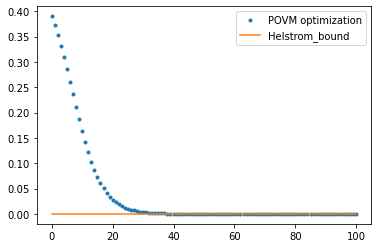

In [14]:
plt.plot(list(range(101)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(101)), [Helstrom_bound]*101, '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [15]:
E = classifier.povm()
rho = classifier.density_matrices
print(E)
rho

(tensor([[0.5+0.00000000e+00j, 0.5-2.27077718e-10j],
        [0.5+2.27077718e-10j, 0.5+0.00000000e+00j]], requires_grad=True), tensor([[ 0.5+0.00000000e+00j, -0.5+2.27077745e-10j],
        [-0.5-2.27077745e-10j,  0.5+0.00000000e+00j]], requires_grad=True))


[tensor([[0.5+0.j, 0.5+0.j],
         [0.5+0.j, 0.5+0.j]], requires_grad=True),
 tensor([[ 0.5+0.j, -0.5+0.j],
         [-0.5+0.j,  0.5+0.j]], requires_grad=True)]

## Three-element POVM

In [2]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]

In [3]:
classifier = POVM_clf(n, wires, bloch_vecs, dev)
#Helstrom_bound = classifier.spectral_decomp()

In [7]:
steps = 300
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.3333348
Cost after step    20:  0.3333340
Cost after step    40:  0.3333337
Cost after step    60:  0.3333335
Cost after step    80:  0.3333334
Cost after step   100:  0.3333334
Cost after step   120:  0.3333334
Cost after step   140:  0.3333333
Cost after step   160:  0.3333333
Cost after step   180:  0.3333333
Cost after step   200:  0.3333333
Cost after step   220:  0.3333333
Cost after step   240:  0.3333333
Cost after step   260:  0.3333333
Cost after step   280:  0.3333333
Cost after step   300:  0.3333333


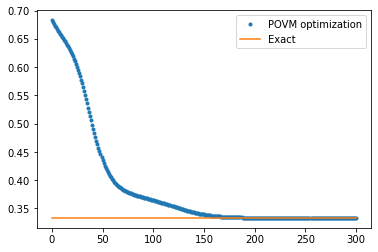

In [5]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(steps+1)), [1/3]*(steps+1), '-', label="Exact")
plt.legend()
plt.show()

In [9]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices
E

(tensor([[ 0.33333331+0.j        , -0.1666756 +0.28866995j],
         [-0.1666756 -0.28866995j,  0.33333331+0.j        ]], requires_grad=True),
 tensor([[0.33334121+0.00000000e+00j, 0.33334121-3.26823487e-06j],
         [0.33334121+3.26823487e-06j, 0.33334121+0.00000000e+00j]], requires_grad=True),
 tensor([[ 0.33332548+0.j        , -0.16666561-0.28866668j],
         [-0.16666561+0.28866668j,  0.33332548+0.j        ]], requires_grad=True))

In [10]:
#PGM
classifier.sq_rt_m()

([tensor([[ 0.33333333-2.13662521e-17j, -0.16666667-2.88675135e-01j],
          [-0.16666667+2.88675135e-01j,  0.33333333-2.13662521e-17j]], requires_grad=True),
  tensor([[0.33333333+0.j, 0.33333333+0.j],
          [0.33333333+0.j, 0.33333333+0.j]], requires_grad=True),
  tensor([[ 0.33333333+2.13662521e-17j, -0.16666667+2.88675135e-01j],
          [-0.16666667-2.88675135e-01j,  0.33333333+2.13662521e-17j]], requires_grad=True)],
 0.3333333333333335)

Bloch Sphere visualization for both initial qubit and measurment direction

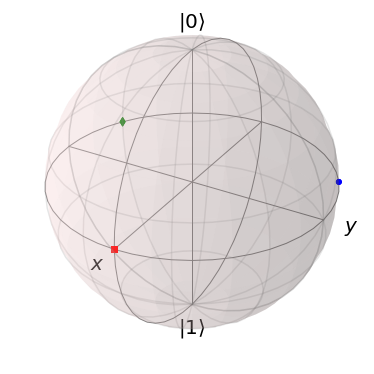

In [11]:
bloch3 = qutip.Bloch()
bloch3.add_points(bloch_vecs[0])
bloch3.add_points(bloch_vecs[1])
bloch3.add_points(bloch_vecs[2])
#bloch3.save('bs_3')
bloch3.show()

---
# Mixed-state Classifier

## Two-element POVM

In [2]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]
bloch_vecs = [[0.2,0,0], [-0.2,0,0]]

In [3]:
classifier = POVM_clf(2, wires, bloch_vecs, devs)
Helstrom_bound_exact = classifier.spectral_decomp()
Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [0.19972839 0.00026379 0.00207314]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.2, 0, 0]
Output Bloch vector =  [-1.99981561e-01 -3.94832138e-04  4.05876477e-05]


In [4]:
classifier.povm_params # np.seed(9)

tensor([ 2.78964846, 10.94194487,  2.59770952, 11.54360512,  6.13755601,
         7.6874001 ,  9.62468198,  6.51463257,  3.7297051 ,  2.35897453,
         1.01462471], requires_grad=True)

In [5]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4780431
Cost after step    20:  0.4616450
Cost after step    40:  0.4418493
Cost after step    60:  0.4242132
Cost after step    80:  0.4124244
Cost after step   100:  0.4059587
Cost after step   120:  0.4027786
Cost after step   140:  0.4012955
Cost after step   160:  0.4006205
Cost after step   180:  0.4003168
Cost after step   200:  0.4001808
Cost after step   220:  0.4001200
Cost after step   240:  0.4000929
Cost after step   260:  0.4000808
Cost after step   280:  0.4000754
Cost after step   300:  0.4000730
Cost after step   320:  0.4000719
Cost after step   340:  0.4000715
Cost after step   360:  0.4000713
Cost after step   380:  0.4000712
Cost after step   400:  0.4000711


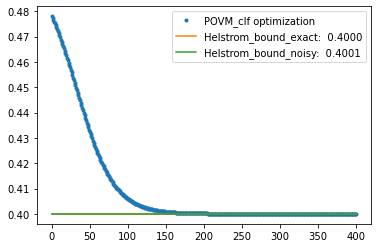

In [8]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [9]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.output_density_matrices

In [10]:
1-(1/2)*sum([np.trace(np.dot(E[i], rho[i])) for i in range(2)])

(0.4000711185692568+0j)

## Three-element POVM

In [2]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2, 3]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.7 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]

In [3]:
classifier = POVM_clf(3, wires, bloch_vecs, devs)
#Helstrom_bound_exact = classifier.spectral_decomp()
#Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, 0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-3.49658984e-01  6.04435215e-01  3.79488450e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0.0, -1.1256858547736456e-16]
Output Bloch vector =  [0.69960602 0.00361334 0.00099011]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.3499999999999998, -0.6062177826491071, -1.1256858547736456e-16]
Output Bloch vector =  [-0.34745206 -0.60689328  0.00339499]


In [4]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.6336004
Cost after step    20:  0.5771539
Cost after step    40:  0.5131474
Cost after step    60:  0.4839263
Cost after step    80:  0.4696159
Cost after step   100:  0.4578364
Cost after step   120:  0.4479082
Cost after step   140:  0.4410716
Cost after step   160:  0.4371852
Cost after step   180:  0.4352521
Cost after step   200:  0.4343635
Cost after step   220:  0.4339696
Cost after step   240:  0.4337960
Cost after step   260:  0.4337181
Cost after step   280:  0.4336817
Cost after step   300:  0.4336638
Cost after step   320:  0.4336545
Cost after step   340:  0.4336495
Cost after step   360:  0.4336465
Cost after step   380:  0.4336448
Cost after step   400:  0.4336438


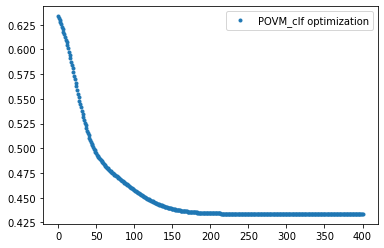

In [5]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
#plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
#plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [6]:
K = classifier.kraus_op()
E = classifier.povm()
rho = classifier.density_matrices

In [9]:
E, 1-(1/3)*sum([np.trace(np.dot(E[i], rho[i])) for i in range(3)])

((tensor([[ 0.3322765 +0.j       , -0.16500713-0.2890783j],
          [-0.16500713+0.2890783j,  0.33343801+0.j       ]], requires_grad=True),
  tensor([[0.33115072+0.j        , 0.33142685-0.00247361j],
          [0.33142685+0.00247361j, 0.33172191+0.j        ]], requires_grad=True),
  tensor([[ 0.33657278+0.j        , -0.16641972+0.29155191j],
          [-0.16641972-0.29155191j,  0.33484008+0.j        ]], requires_grad=True)),
 (0.43333781837421026+0j))

In [10]:
pgm, cost_pgm = classifier.sq_rt_m()
pgm, cost_pgm

([tensor([[ 0.33333333-1.12172823e-17j, -0.11666667-2.02072594e-01j],
          [-0.11666667+2.02072594e-01j,  0.33333333-1.12172823e-17j]], requires_grad=True),
  tensor([[0.33333333+0.j, 0.23333333+0.j],
          [0.23333333+0.j, 0.33333333+0.j]], requires_grad=True),
  tensor([[ 0.33333333+1.12172823e-17j, -0.11666667+2.02072594e-01j],
          [-0.11666667-2.02072594e-01j,  0.33333333+1.12172823e-17j]], requires_grad=True)],
 0.5033333333333334)

$$
\text{Tr}[\hat{\rho}_i\hat{E}_i]
$$

In [11]:
[np.real(np.trace(np.dot(rho[i], pgm[i]))) for i in range(3)]

[0.4966666666666666, 0.4966666666666666, 0.4966666666666666]

In [12]:
[np.real(np.trace(np.dot(rho[i], E[i]))) for i in range(3)]

[0.5658541561961943, 0.5634351069452088, 0.5706972817359661]

In [13]:
np.dot(rho[0], rho[1])

tensor([[0.18875-0.10608811j, 0.0875 -0.15155445j],
        [0.0875 +0.15155445j, 0.18875+0.10608811j]], requires_grad=True)

In [14]:
i, j = 0, 1
np.dot(np.dot(pgm[i], rho[i] - rho[j]), pgm[j])

tensor([[ 5.59737442e-18+5.80039465e-19j,
         -2.97500000e-02-1.71761705e-02j],
        [-2.97500000e-02+1.71761705e-02j,
          9.29811783e-18-2.16076401e-18j]], requires_grad=True)

In [15]:
i, j = 1, 2
np.dot(np.dot(E[i], rho[i] - rho[j]), E[j])

tensor([[0.00061852-0.00060869j, 0.00022145+0.00083674j],
        [0.00062362-0.00060455j, 0.00021534+0.00083912j]], requires_grad=True)

---
# For various purities $\mathcal{P}$,

$\hat{\rho} = \frac{1}{2}(I+\vec{a}\cdot\hat{\sigma})$ <br>
$
\mathcal{P} = Tr[\hat{\rho}^2] = \frac{1}{2}(1+|\vec{a}|^2) \Longrightarrow
|\vec{a}| = \sqrt{2\mathcal{P}-1}
$ 

## Case 1
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (-\sqrt{2\mathcal{P}-1}, 0, 0)$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
ampltd_abs = [1, 0.7, 0.4, 0.1]
#Pure state


#Mixed state
steps = [100, 150, 200, 400]
for i, a in enumerate(ampltd_abs):
    
    bloch_vecs = [[a,0,0], [(-1)*a,0,0]]
    if a == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

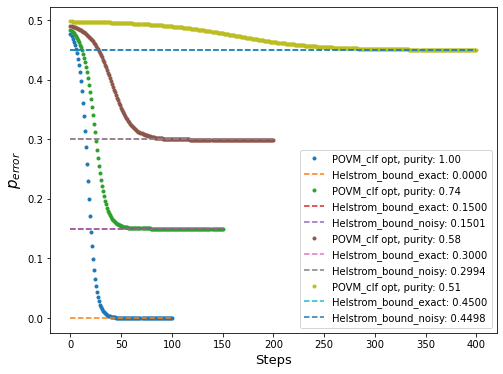

In [14]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((ampltd_abs[i]**2+1)/2))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_exact: {:.4f}".format(Hbe_list[i]))
    if i !=0:
        plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound_noisy: {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result1.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 2
$\vec{a}_1 = (\sqrt{2\mathcal{P}-1}, 0, 0)$  
$\vec{a}_2 = (0, 0, \sqrt{2\mathcal{P}-1})$

In [ ]:
n_qubit = 3
wires = [0, 1, 2]
n_outcome = 2
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list, Hbe_list, Hbn_list = [], [], []
purities = [1, 0.85, 0.7, 0.55]


steps = [130, 170, 250, 500]
for i, p in enumerate(purities):
    
    bloch_vecs = [[np.sqrt(2*p-1),0,0], [0,0,np.sqrt(2*p-1)]]
    if p == 1:
        classifier =POVM_clf(2, wires[:2], bloch_vecs, devs[:2])
        cost_list.append(classifier.run_opt(steps[i]))
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp())

    else:
        classifier = POVM_clf(2, wires, bloch_vecs, devs)
        Hbe_list.append(classifier.spectral_decomp())
        Hbn_list.append(classifier.spectral_decomp(types='noisy'))

        cost_list.append(classifier.run_opt(steps[i]))

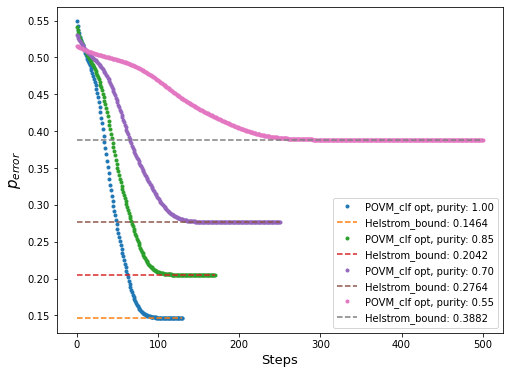

In [86]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="POVM_clf opt, purity:{: .2f}".format((purities[i])))
    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound: {:.4f}".format(Hbe_list[i]))
    #if i !=0:
    #    plt.plot(list(range(steps[i]+1)), [Hbe_list[i]]*(steps[i]+1), '--', label="Helstrom_bound, "+r"$\rho_{noisy}$"+": {:.4f}".format(Hbn_list[i]))

plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$p_{error}$', fontsize=15)
plt.legend()
plt.savefig('result2.png', bbox_inches='tight', transparent=True)
plt.show()

## Case 3
$|\psi_0\rangle = \left(|0\rangle + e^{2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_0=\sqrt{2\mathcal{P}-1}(-1/2, \sqrt{3}/2, 0)$<br>
$|\psi_1\rangle = \left(|0\rangle+|1\rangle\right)/\sqrt{2}$       ========> $\vec{a}_1 = \sqrt{2\mathcal{P}-1}(1,0,0) $ <br>
$|\psi_2\rangle = \left(|0\rangle + e^{-2\pi i /3}|1\rangle\right)/\sqrt{2}$ ===> $\vec{a}_2 = \sqrt{2\mathcal{P}-1}(-1/2, -\sqrt{3}/2, 0)$

In [17]:
n_qubit = 4
wires = [0, 1, 2, 3]
n_outcome = 3
devs = [qml.device('default.qubit', wires=n_qubit)] * n_outcome

cost_list= []
cost_pgm_list = []
purities = [1, 0.85, 0.7, 0.55]
steps = [250, 300, 350, 400]

for i, p in enumerate(purities):    
    state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
    bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
    bloch_vecs = [[np.sqrt(2*p-1) * bloch_vecs[n][i] for i in range(3)] for n in range(n)]

    if p == 1:
        classifier =POVM_clf(3, wires[:3], bloch_vecs, devs[:3])
        cost_list.append(classifier.run_opt(steps[i]))

    else:
        classifier = POVM_clf(3, wires, bloch_vecs, devs)
        cost_list.append(classifier.run_opt(steps[i]))

    pgm, cost_pgm = classifier.sq_rt_m()
    cost_pgm_list.append(cost_pgm)

Cost(init_params)    :  0.6743586
Cost after step    20:  0.6557505
Cost after step    40:  0.6067046
Cost after step    60:  0.4605373
Cost after step    80:  0.4036042
Cost after step   100:  0.3920694
Cost after step   120:  0.3865024
Cost after step   140:  0.3828515
Cost after step   160:  0.3806185
Cost after step   180:  0.3793727
Cost after step   200:  0.3787141
Cost after step   220:  0.3783734
Cost after step   240:  0.3781973
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.4183300132670376, 0.7245688373094721, -1.3454519387485027e-16]
Output Bloch vector =  [-0.41637466  0.72724821 -0.00172999]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8366600265340756, 0.0, -1.3454519387485027e-16]
Output Bloch vector =  [8.36412110e-01 7.10529668e-04 2.09797910e-03]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.4183300132670376, -0

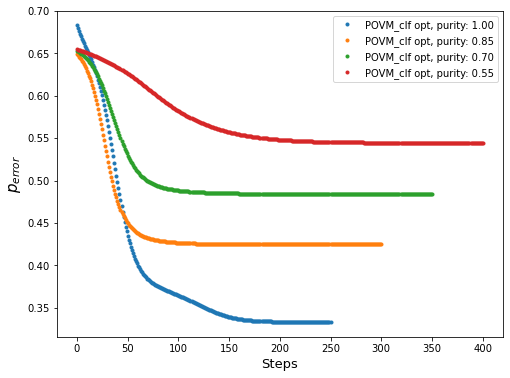

In [84]:
plt.figure(figsize=(8,6))
for i in range(len(cost_list)):
    plt.plot(list(range(steps[i]+1)), cost_list[i], '.', label="Purity:{: .2f}".format((purities[i])))
    #cost_pgm
    plt.plot(list(range(steps[i]+1)), [cost_pgm_list[i]]*(steps[i]+1), '--', label="PGM, Purity:{: .2f}".format((purities[i])))


plt.xlabel('Steps', fontsize=13)
plt.ylabel(r'$C(\Theta)$', fontsize=20, usetex=True)
plt.legend()
#plt.savefig('result3.png', bbox_inches='tight', transparent=True)
plt.show()

그래프 조금 더 다듬기

---
---
---
# Test

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

from povm_clf import *

In [2]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n#, qml.device('default.qubit', wires=n), qml.device('default.qubit', wires=n)] 
wires = [0, 1, 2]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)] 

In [3]:
np.random.seed(2)
params = 4 * np.pi * np.random.random([19])
params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [8]:
params_opt = np.array([2.07716568, 7.85397763, 0.5236459 , 3.14159269, 1.23291917,
        1.59793933, 7.49892272, 2.84015056, 1.0471506 , 1.59700472,
        4.39604675, 6.28317501, 3.14158859, 8.04758825, 6.07043459,
        6.34899187, 4.86183644, 9.97314239, 7.28854747])
classifier = POVM_clf(n, wires, bloch_vecs, dev)
classifier.cost_fn(params), classifier.cost_fn(params_opt)

[8.18281620e-01 4.81482486e-35 1.22542914e-01 5.91754651e-02]
[7.98603265e-01 2.04630057e-34 1.52876822e-01 4.85199128e-02]
[8.03528796e-01 4.81952684e-35 1.60807782e-01 3.56634215e-02]


(0.6617490587001609, 0.4986002199858599)

In [9]:
classifier.povm_params

tensor([ 5.47887353,  0.32579864,  6.90726241,  5.47042252,  5.2824976 ,
         4.15110979,  2.57169058,  7.78198847,  3.76557169,  3.35305043,
         7.80539794,  6.64939566,  1.69118147,  6.45381301,  2.31773971,
         9.86881252, 10.73137002,  6.21076327, 10.63820537], requires_grad=True)

In [6]:
qnodes = qml.QNodeCollection()
for i in range(3):
    povm_circ = SingleQubitPOVM(n=3, bloch_vec = bloch_vecs[i])
    qnode = povm_circ(wires=wires, dev=dev[i])
    qnodes.append(qnode)
probs_povm = qnodes(params)
probs_povm

array([[8.18281620e-01, 4.81482486e-35, 1.22542914e-01, 5.91754651e-02],
       [7.98603265e-01, 2.04630057e-34, 1.52876822e-01, 4.85199128e-02],
       [8.03528796e-01, 4.81952684e-35, 1.60807782e-01, 3.56634215e-02]])

In [8]:
print(probs_povm[0][0], probs_povm[1][2], probs_povm[2][3])

0.818281620388223 0.15287682182133314 0.035663421536471875


---
---
---